In [1]:
import Pkg
Pkg.activate(@__DIR__)

  Activating project at `~/github/code/invariance-code`


In [2]:
using LinearAlgebra, Plots, ProgressMeter, Pipe
using Random, Statistics, Distributions, LaTeXStrings
using Ripserer, PersistenceDiagrams

In [3]:
A = [I(10) zeros(10, 10); ones(10, 20)] ./ 2;
B = [ones(5, 20); zeros(10, 5) I(10) zeros(10, 5); ones(5, 20)] ./ 2;

In [4]:
function rand_chisq(A, B; vec = rand(4))
    vec = sqrt.(sum(vec) ./ vec)
    x = randn(size(A, 1))
    s, t = sign.(x)'
    if s < 0 && t < 0
        u, v = s * (x'A*x), t * (x'B*x)
        u, v = (u, v) ./ vec[1]
    elseif s < 0 && t > 0
        u, v = s * (x'A*x), t * (x'B*x)
        u, v = (u, v) ./ vec[2]
    elseif s > 0 && t < 0
        u, v = s * (x'A*x), t * (x'B*x)
        u, v = (u, v) ./ vec[3]
    elseif s > 0 && t > 0
        u, v = s * (x'A*x), t * (x'B*x)
        u, v = (u, v) ./ vec[4]
end
    return (u, v)
end

rand_chisq (generic function with 1 method)

[0.46 0.47 0.03 0.04; 0.17 0.39 0.21 0.24]


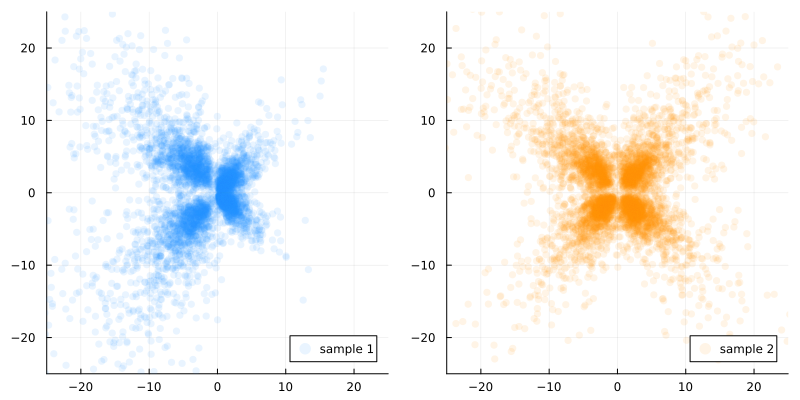

In [5]:
Random.seed!(314159)
v1, v2 = rand(4), rand(4)
x, y = [rand_chisq(A, B; vec=v1) for _ in 1:5000], [rand_chisq(A, B; vec=v2) for _ in 1:5000]

println(@pipe [v1 ./ sum(v1) v2 ./ sum(v2)] .|> round(_, digits=2) |> transpose)

plot_scatter_1 = scatter(x, ma=0.1, msw=0, lim=(-25, 25), c=:dodgerblue, size=(400, 400), label="sample 1")
plot_scatter_2 = scatter(y, ma=0.1, msw=0, lim=(-25, 25), c=:darkorange, size=(400, 400), label="sample 2")
plot(plot_scatter_1, plot_scatter_2, size=(800, 400))

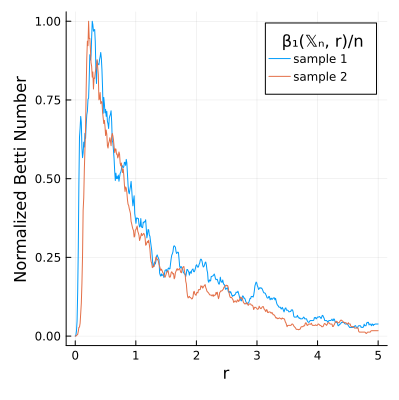

In [6]:
xs = range(0, 5, length=500)
d1, d2 = ripserer(Alpha(x), dim_max=1), ripserer(Alpha(y), dim_max=1)
c1, c2 = BettiCurve(extrema(xs)..., length = length(xs), normalize=false).((d1[2], d2[2])) ./ 5000
plot_curve = plot(xs, c1 ./ maximum(c1), label="sample 1", )
plot_curve = plot(plot_curve, xs, c2 ./ maximum(c2), label="sample 2")
plot_curve = plot(plot_curve, legendtitle="β₁(𝕏ₙ, r)/n", xl = "r", yl="Normalized Betti Number", size=(400,400))
plot_curve

---

In [7]:
function simulate_curve(n; seed=0, A, B, dim=1, seq=range(0, 1, length=100), kwargs...)

    w = rand(MersenneTwister(seed), 4)
    x = [rand_chisq(A, B; vec = w) for _ in 1:n]

    D = ripserer(Alpha(x), dim_max = 1)

    curve = BettiCurve(extrema(seq)..., length=length(seq); kwargs...)
    b = curve(D[1 + dim])

    return b
end

simulate_curve (generic function with 1 method)

In [8]:
function plt(B; seq=range(0, 1, length=10), v=nothing, kwargs...)
    p = plot(seq, B, label="", c=:black, la=0.1, lw=1; kwargs...)
    p = plot(p, seq, mean.(eachrow(B)), label="", c=:black, lw=1)
    if !isnothing(v)
        p = vline(p, [v], label="", c=:red, la=0.5, ls=:dash)
    end
    return p
end


function combined_plt(Bs; seq=range(0, 1, length=100), v=nothing, labs=N, kwargs...)
    p = plot(seq, 0; kwargs...)
    
    cls = distinguishable_colors(1 + size(Bs, 3), colorant"black")[[1; 3:end]]

    for (b, i) in zip(eachslice(Bs, dims=3), axes(Bs, 3))
        p = plot(p, seq, b, label="", c=cls[i], la=0.1, lw=1)
        p = plot(p, seq, mean.(eachrow(b)), label="n=$(N[i])", c=cls[i], lw=1)
        if !isnothing(v)
            p = vline(p, [v[i]], label="", c=:red, la=0.5, ls=:dash)
        end
    end

    return p
end

combined_plt (generic function with 1 method)

---

In [9]:
# 3 different values of n with 20 random parametrizations for each n
N = [1_000, 5_000, 10_000]
reps = 20
x_seq = range(0, 5, length=500)

sim_1(n, j) = simulate_curve(n; seed=j, A=A, B=B, dim=1, seq=x_seq, normalize=false, integrate=true) ./ n

sim_1 (generic function with 1 method)

In [10]:
X = zeros(size(x_seq, 1), reps, size(N, 1))
@showprogress for i in 1:reps, j in eachindex(N)
    X[:, i, j] .= sim_1(N[j], i)
end;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:18


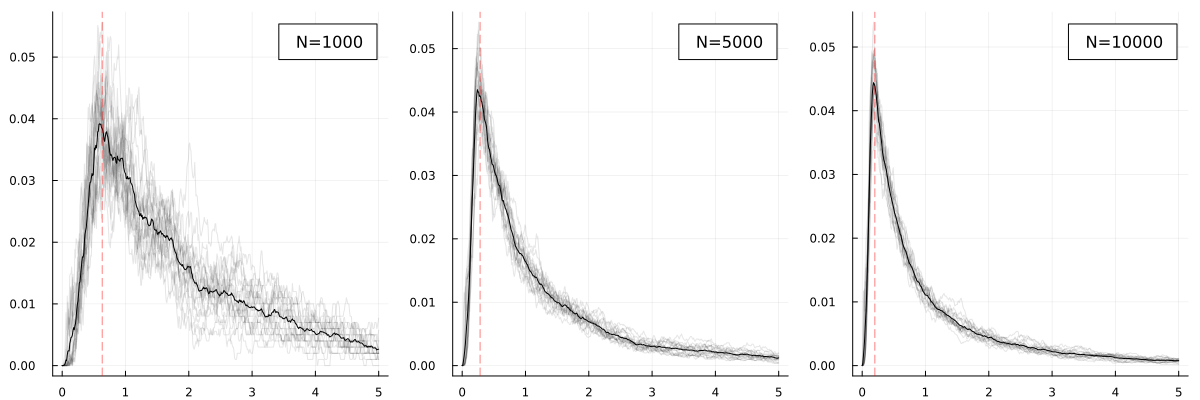

In [11]:
line_plts = map((x, n) -> plt(x, seq=x_seq, size=(400, 400), v=20 / sqrt(n)), eachslice(X, dims=3), N)

plot(
    line_plts...,
    layout=(1, size(N, 1)), 
    legendtitle = ["N=$n" for n in reshape(N, 1, :)],
    size=(400 * size(N, 1), 400)
)

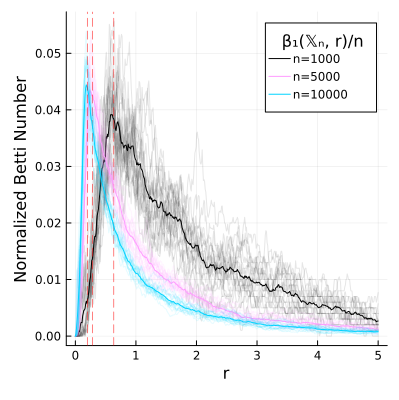

In [12]:
plot_combined = combined_plt(X, seq=x_seq, labs=N, v=20 ./ sqrt.(N))
plot_combined = plot(plot_combined, xl = "r", yl="Normalized Betti Number", legendtitle="β₁(𝕏ₙ, r)/n", size=(400,400))

---

## Fixed resolution $r_n$ but varying $n$

$$
\beta_1(\mathbb{X}_n, r_n) \quad \text{for } r_n = t n^{-1/2}
$$
where $t=20$ is chosen to correspond to the dashed red lines in the previous plot. 

In [13]:
N = [1_000, 5_000, 10_000, 15_000, 20_000]
reps = 30

# Generate 3 different paramterizations of the family of distributions
random_seeds = rand(MersenneTwister(0), 1:100, 3)

# r(n, t) function
r(n; t) = t * n^(-0.5)

sim_2(n, j) = simulate_curve(
        n; seed= j, 
        A=A, B=B, dim=1, 
        seq=range(r(n; t=20.0), r(n; t=20.0), length=1),
        normalize=false, integrate=false
    )[1] ./ n

sim_2 (generic function with 1 method)

In [14]:
Y = @showprogress [sim_2(n, k) for k in random_seeds, j in 1:reps, n in N];

Progress: 100%|█████████████████████████████████████████| Time: 0:05:37


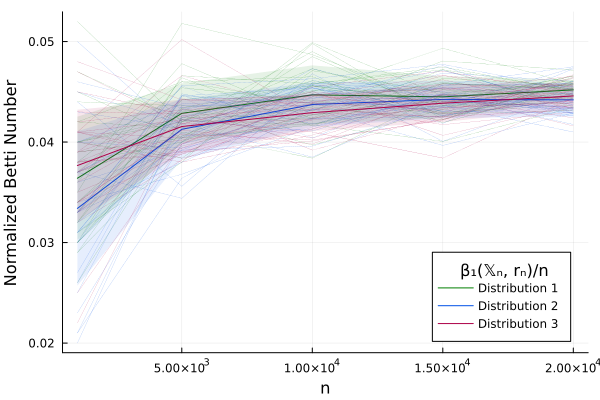

In [15]:
plot_rn = plot(N, 0, label="", xl="n", yl="Normalized Betti Number")
cls = distinguishable_colors(3 * size(random_seeds, 1))[end-3:end]
for k in eachindex(random_seeds)
    plot_rn = plot(plot_rn, N, mean.(eachcol(Y[k, :, :])), ribbon=std.(eachcol(Y[k, :, :])), c=cls[k], lw=1,  fa=0.1, label="Distribution $k")    
    plot_rn = plot(plot_rn, N, Y[k, :, :]', label="", lw=0.1, la=1, c=cls[k])
end
plot_rn = plot(plot_rn, legend=:bottomright, legendtitle="β₁(𝕏ₙ, rₙ)/n")

---